In [1]:
from collections import OrderedDict
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim

import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [2]:
class MyImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
            
        return image

transform = transforms.Compose([
    transforms.ToTensor(),
])

data_dir = '/home/dominhnhat/Classroom/generative_model/data/CIFAR_32/train'
dataset = MyImageDataset(image_dir=data_dir, transform=transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [3]:
class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.BatchNorm2d(dim),
            nn.ReLU(),
            nn.Conv2d(dim, dim, 3, 1, 1),
            nn.BatchNorm2d(dim),
            nn.ReLU(),
            nn.Conv2d(dim, dim, 1)
        )
    def forward(self, x):
        return x + self.net(x)



class LayerNorm(nn.LayerNorm):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    def forward(self, x):
        x = x.permute(0, 2, 3, 1).contiguous()
        x_shape = x.shape
        x = super().forward(x)
        return x.permute(0, 3, 1, 2).contiguous()



class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 256, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 4, stride=2, padding=1),
            ResidualBlock(256),
            ResidualBlock(256),
        )
    def forward(self, x):
        return self.net(x)



class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            ResidualBlock(256),
            ResidualBlock(256),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256, 256, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256, 3, 4, stride=2, padding=1),
            #nn.Tanh(), i mean, why ???
        )
    def forward(self, x):
        return self.net(x)



class Quantize(nn.Module):
    def __init__(self, size, code_dim):
        super().__init__()
        self.embedding = nn.Embedding(size, code_dim)
        self.embedding.weight.data.uniform_(-1./size,1./size)
        self.code_dim = code_dim
        self.size = size
    def forward(self, z):
        b, c, h, w = z.shape
        #print(z.shape)
        weight = self.embedding.weight

        flat_inputs = z.permute(0, 2, 3, 1).contiguous().view(-1, self.code_dim)
        #print(f"flat input size : {flat_inputs.shape}")
        #print(self.code_dim)
        #calculate norm2 distance
        distances = (flat_inputs ** 2).sum(dim=1, keepdim=True) \
                    - 2 * torch.mm(flat_inputs, weight.t()) \
                    + (weight.t() ** 2).sum(dim=0, keepdim=True)


        #print((flat_inputs ** 2).sum(dim=1, keepdim=True).shape)
        #print(2 * torch.mm(flat_inputs, weight.t()).shape)
        #print((weight.t() ** 2).sum(dim=0, keepdim=True).shape) 
        #print(distances.shape)   

        #take the minimum value
        encoding_indices = torch.max(-distances, dim=1)[1]
        encoding_indices = encoding_indices.view(b, h, w)
        quantized = self.embedding(encoding_indices).permute(0, 3, 1, 2).contiguous()

        return quantized, (quantized - z).detach() + z, encoding_indices

class VQ_VAE(nn.Module):
    def __init__(self, code_dim, code_size):
        super().__init__()
        self.code_dim = code_dim
        self.code_size = code_size
        self.encoder = Encoder()
        self.codebook = Quantize(code_size, code_dim)
        self.decoder = Decoder()
    
    def forward(self, x):
        z = self.encoder(x)
        e, e_st, _ = self.codebook(z)
        x_tilde = self.decoder(e_st)
        diff1 = torch.mean((z - e.detach()) ** 2)
        diff2 = torch.mean((e - z.detach()) ** 2)
        return x_tilde, diff1 + diff2
    
    def loss(self, x):
        x_tilde, diff = self(x)
        recon_loss = F.mse_loss(x_tilde, x)
        loss = recon_loss + diff
        return OrderedDict(loss=loss, recon_loss=recon_loss, reg_loss=diff)
    
    def reconstruct_image(self, x):
        with torch.no_grad():
            z = self.encoder(x)
            e, e_st, _ = self.codebook(z)
            x_tilde = self.decoder(e_st)
            return x_tilde
    
    def sample(self, n):
        with torch.no_grad():
            z = torch.rand(n, 256, 8, 8).cuda()
            e, e_st, _ = self.codebook(z)
            x_recon = torch.clamp(self.decoder(e_st), 0, 1)
            return x_recon.cpu().permute(0, 2, 3, 1).numpy()



#-------------------------- Define model -----------------------------------------------

code_dim, code_size = 256, 128
model = VQ_VAE(code_dim, code_size).cuda()
optimizer = optim.Adam(model.parameters(), lr=5e-4)
epochs = 50

#-------------------------- Training loop ------------------------------------------------

def evaluate_test_loss(model, dataloader):
    model.eval()
    elbo_loss, recon_loss, reg_loss = [], [], []
    for x in dataloader:
        x = x.cuda()
        out = model.loss(x)

        elbo_loss.append(out['loss'].item())
        recon_loss.append(out['recon_loss'].item())
        reg_loss.append(out['reg_loss'].item())
    
    print(np.mean(elbo_loss), np.mean(recon_loss), np.mean(reg_loss))
    return np.mean(elbo_loss), np.mean(recon_loss), np.mean(reg_loss)

def train_1_epoch(epoch_num, model, optimizer, dataloader, show_result = True):
    model.train()

    print(f'epoch number {epoch_num}' + '-'*30)
    elbo_loss, recon_loss, reg_loss = [], [], []
    for batch, X in enumerate(dataloader):
        X = X.cuda()
        out = model.loss(X)
        optimizer.zero_grad()

        out['loss'].backward()

        if (show_result == True and batch % 100 == 0):
            print(f"Batch Elbo loss :{out['loss'].item()} | Batch Recon loss : {out['recon_loss'].item()} | Batch KL loss : {out['reg_loss'].item()}")

        elbo_loss.append(out['loss'].item())
        recon_loss.append(out['recon_loss'].item())
        reg_loss.append(out['reg_loss'].item())
        optimizer.step()
    
    if (show_result == True):
        print(np.mean(elbo_loss), np.mean(recon_loss), np.mean(reg_loss))
    return np.mean(elbo_loss), np.mean(recon_loss), np.mean(reg_loss)

def train(model, optimizer, epochs, train_data, test_data):
    train_losses, test_losses = [], []
    for epoch in range(epochs):
        train_loss = train_1_epoch(epoch, model, optimizer, train_data)
        test_loss = evaluate_test_loss(model, test_data)
        train_losses.append(np.array(train_loss))
        test_losses.append(np.array(test_loss))


#------------------------------ train model ----------------------------------------------
train(model, optimizer, epochs, train_dataloader, test_dataloader)

#------------------------------ load model -----------------------------------------------
#model.load_state_dict(torch.load('/home/dominhnhat/Classroom/generative_model/trained_model/VQVAE.pth'))

epoch number 0------------------------------
Batch Elbo loss :8.088543891906738 | Batch Recon loss : 7.002685070037842 | Batch KL loss : 1.0858584642410278
Batch Elbo loss :5.057987689971924 | Batch Recon loss : 0.03510408103466034 | Batch KL loss : 5.022883415222168
Batch Elbo loss :1.699079990386963 | Batch Recon loss : 0.028932375833392143 | Batch KL loss : 1.6701476573944092
Batch Elbo loss :0.8364655375480652 | Batch Recon loss : 0.024874210357666016 | Batch KL loss : 0.8115913271903992
4.845666179832178 0.1290450601484448 4.7166211168986925
0.7479336163665675 0.025006951811381534 0.7229266634470299
epoch number 1------------------------------
Batch Elbo loss :0.7592833638191223 | Batch Recon loss : 0.0247267447412014 | Batch KL loss : 0.7345566153526306
Batch Elbo loss :0.48488059639930725 | Batch Recon loss : 0.021836310625076294 | Batch KL loss : 0.46304428577423096
Batch Elbo loss :0.37929806113243103 | Batch Recon loss : 0.021617552265524864 | Batch KL loss : 0.35768049955368

In [5]:
torch.save(model.state_dict(), "/home/dominhnhat/Classroom/generative_model/trained_model/VQVAE.pth")

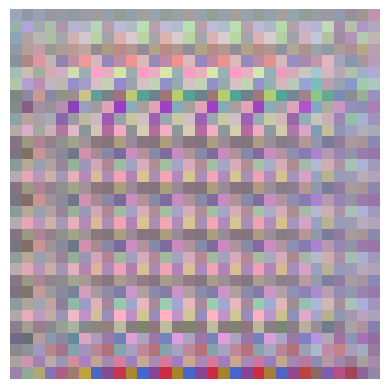

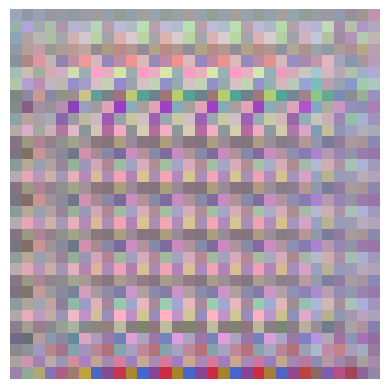

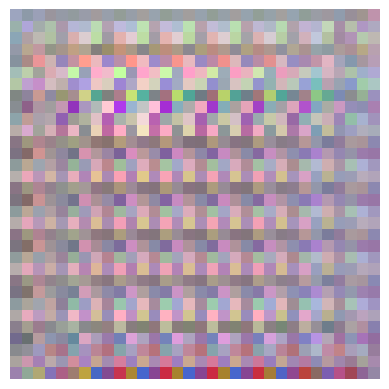

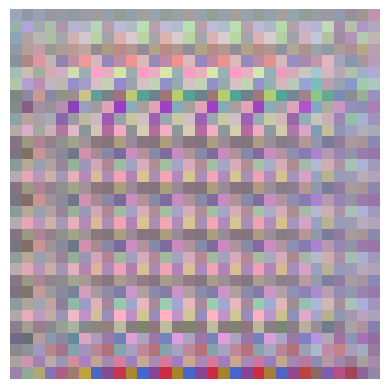

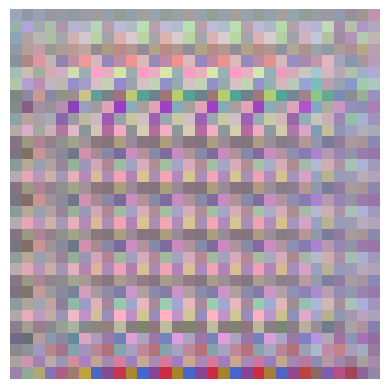

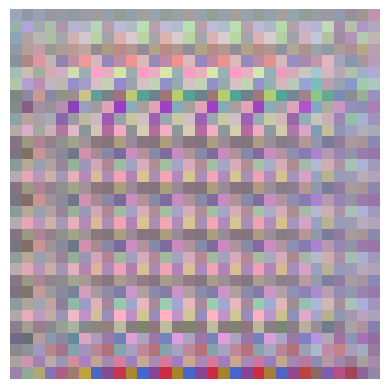

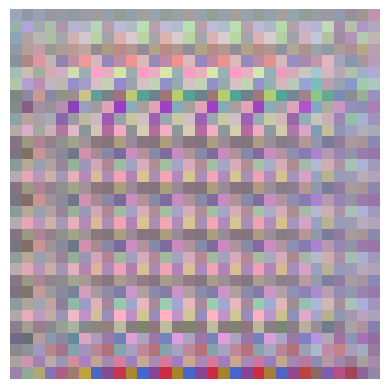

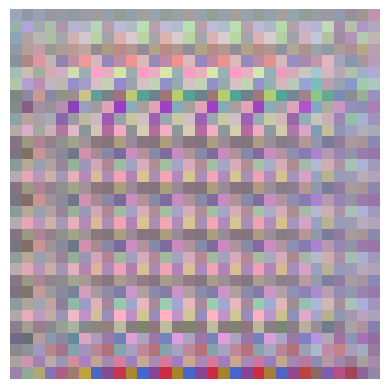

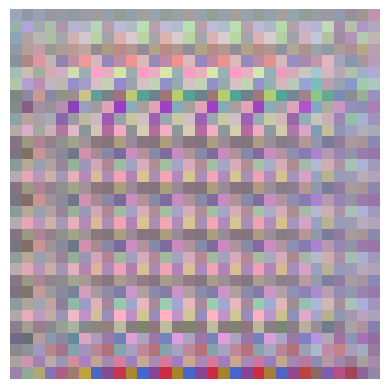

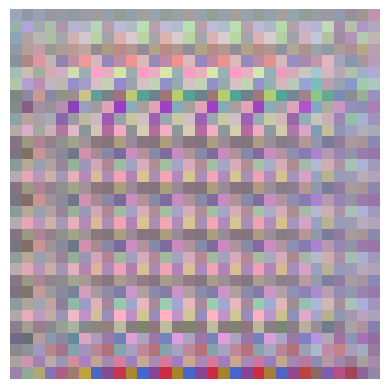

In [6]:
generated_images = model.sample(10)
for image in generated_images:
    plt.imshow(image)
    plt.axis('off')  # Turn off axis labels
    plt.show()
    #break

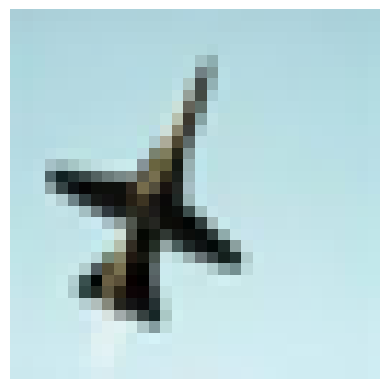

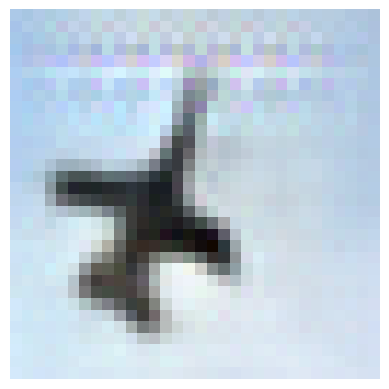

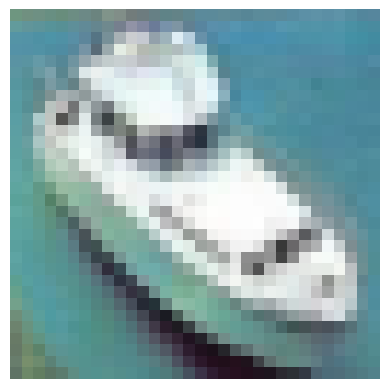

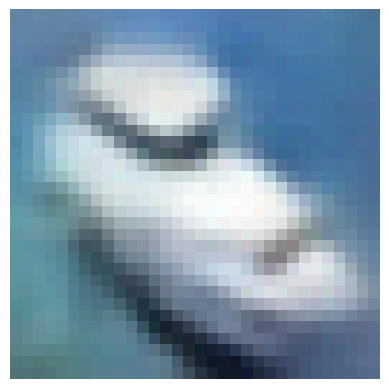

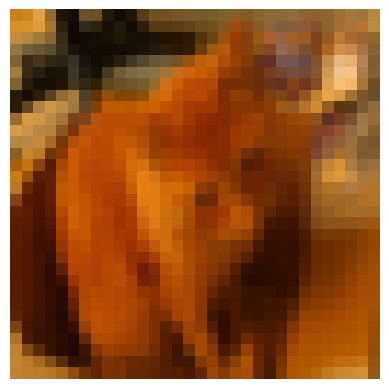

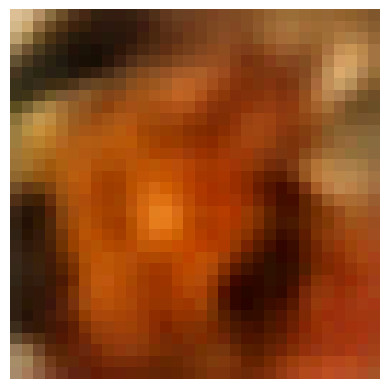

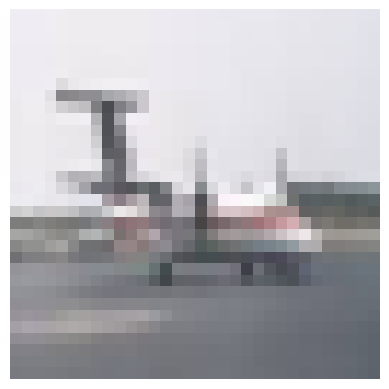

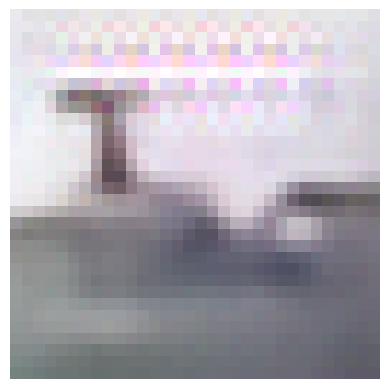

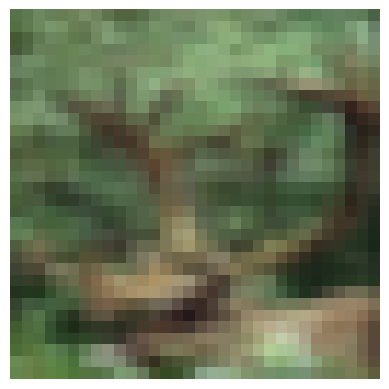

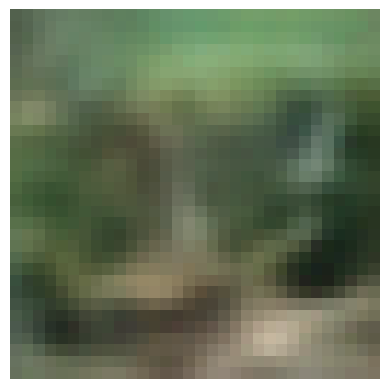

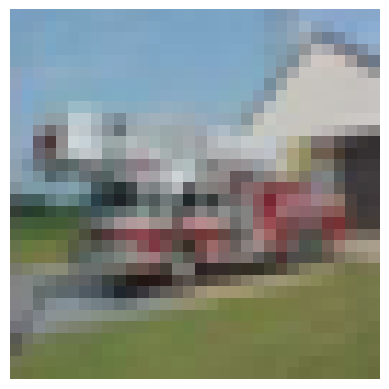

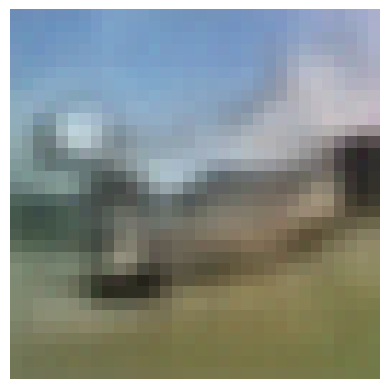

In [7]:
import random

#reconstructing image
for batch, images in enumerate(test_dataloader):
    images = images.cuda()
    tmp = images

    x_recon = model.reconstruct_image(tmp)
    x_recon = torch.clamp(x_recon, 0, 1)

    x_recon = x_recon.detach().cpu().permute(0, 2, 3, 1).numpy()
    tmp = tmp.detach().cpu().permute(0, 2, 3, 1).numpy()

    rd = random.randint(0, 20)
    plt.imshow(tmp[rd])
    plt.axis('off')  # Turn off axis labels
    plt.show()

    plt.imshow(x_recon[rd])
    plt.axis('off')  # Turn off axis labels
    plt.show()
    
    if (batch == 5): 
        break